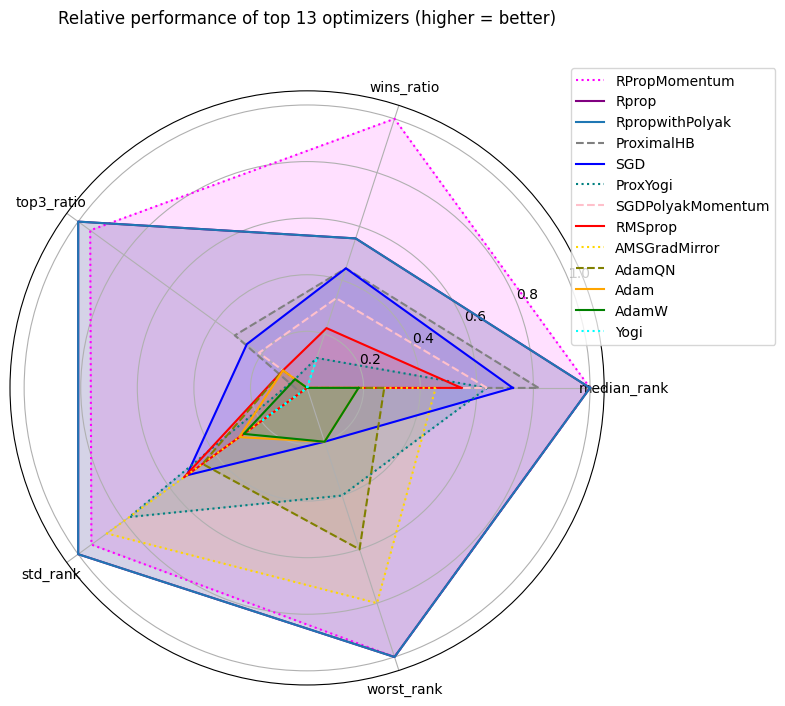

In [41]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, os
from math import pi

# ─── 0 ▸ CONFIG ───────────────────────────────────────────────────────────
csv_path = "/home/yash/Codes/AOMML/Custom Optimizer and Benchmarking/results/functions/_summary.csv"
top_k    = 13                                   # how many optimizers on the radar

# summary metrics (key = column name, value = 'higher' or 'lower' is better)
metrics  = {
    "median_rank": "lower",
    "wins_ratio":  "higher",
    "top3_ratio":  "higher",
    "std_rank":    "lower",
    "worst_rank":  "lower",
}

# ─── 1 ▸ LOAD + PREP ──────────────────────────────────────────────────────
df = pd.read_csv(csv_path)

rank_tbl = (
    df.pivot(index="function", columns="optimizer", values="rank")
      .sort_index()
)                                           # rows = functions, cols = optimizers

rank_tbl = rank_tbl[rank_tbl.nunique(axis=1) > 1]   # drop tie‑rows
n_funcs   = len(rank_tbl)

# ─── 2 ▸ METRICS ──────────────────────────────────────────────────────────
m = pd.DataFrame(index=rank_tbl.columns)

m["median_rank"] = rank_tbl.median()
m["wins_ratio"]  = (rank_tbl == 1).sum()
m["top3_ratio"]  = (rank_tbl <= 3).sum()
m["std_rank"]    = rank_tbl.std()
m["worst_rank"]  = rank_tbl.max()

# keep only the top‑k by median performance
m = m.sort_values("median_rank").head(top_k)

# ─── 3 ▸ NORMALISE so 1 = best, 0 = worst per metric ──────────────────────
norm = m.copy()
for col, sense in metrics.items():
    col_min = m[col].min()
    col_max = m[col].max()
    if col_max == col_min:
        norm[col] = 0.5  # neutral if no variation
    elif sense == "higher":
        norm[col] = (m[col] - col_min) / (col_max - col_min)
    else:  # lower is better
        norm[col] = (col_max - m[col]) / (col_max - col_min)


# ─── 4 ▸ RADAR PLOT ────────────────────────────────────────────────────────
labels     = list(metrics.keys())
num_axes   = len(labels)
angles     = [n / num_axes * 2 * pi for n in range(num_axes)] + [0]

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# ─── 0 ▸ add your style dictionary up‑front ───────────────────────────────
optimizer_styles = {
    # — Standard optimizers (solid lines) —
    'SGD':     {'linestyle': '-',  'color': 'blue'},
    'Adam':    {'linestyle': '-',  'color': 'orange'},
    'AdamW':   {'linestyle': '-',  'color': 'green'},
    'RMSprop': {'linestyle': '-',  'color': 'red'},
    'Rprop':   {'linestyle': '-',  'color': 'purple'},

    # — Bad‐performing customs (dashed lines) —
    'RpropWithPolyakAveraging': {'linestyle': '--', 'color': 'brown'},
    'SGDPolyakMomentum':        {'linestyle': '--', 'color': 'pink'},
    'ProximalHB':               {'linestyle': '--', 'color': 'gray'},
    'AdamQN':                   {'linestyle': '--', 'color': 'olive'},

    # — Good‐performing customs (dotted lines) —
    'Yogi':          {'linestyle': ':',  'color': 'cyan'},
    'RPropMomentum': {'linestyle': ':',  'color': 'magenta'},
    'ProxYogi':      {'linestyle': ':',  'color': 'teal'},
    'AMSGradMirror': {'linestyle': ':',  'color': 'gold'},
}

# ─── where you loop over optimizers to draw the radar ────────────────────
for opt, row in norm.iterrows():
    values = row.tolist() + [row.iloc[0]]        # close the polygon
    
    # look up style; fall back to solid black if the optimizer isn’t mapped
    style   = optimizer_styles.get(opt, {})
    ls      = style.get('linestyle', '-')        # default solid
    colour  = style.get('color',     None)       # default Matplotlib colour

    ax.plot(angles, values,
            linestyle=ls,
            color=colour,
            linewidth=1.5,
            label=opt)
    # faint fill in the *same* colour
    ax.fill(angles, values,
            color=colour,
            alpha=0.12)


ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, size=10)
# ax.set_yticks([0.25, 0.5, 0.75, 1.0])
# ax.set_yticklabels(["0.25", "0.5", "0.75", "1.0"], size=8)
ax.set_title(f"Relative performance of top {top_k} optimizers (higher = better)", y=1.10)
ax.legend(loc='upper right', bbox_to_anchor=(1.30, 1.05))
plt.tight_layout()
plt.show()

# ─── 5 ▸ OPTIONAL: save the normalised table for later ────────────────────
norm.to_csv("/home/yash/Codes/AOMML/Custom Optimizer and Benchmarking/results/functions/radar_metrics.csv")


Dropped 23 / 47 functions because every optimizer tied (list stored in 'neutral_funcs').


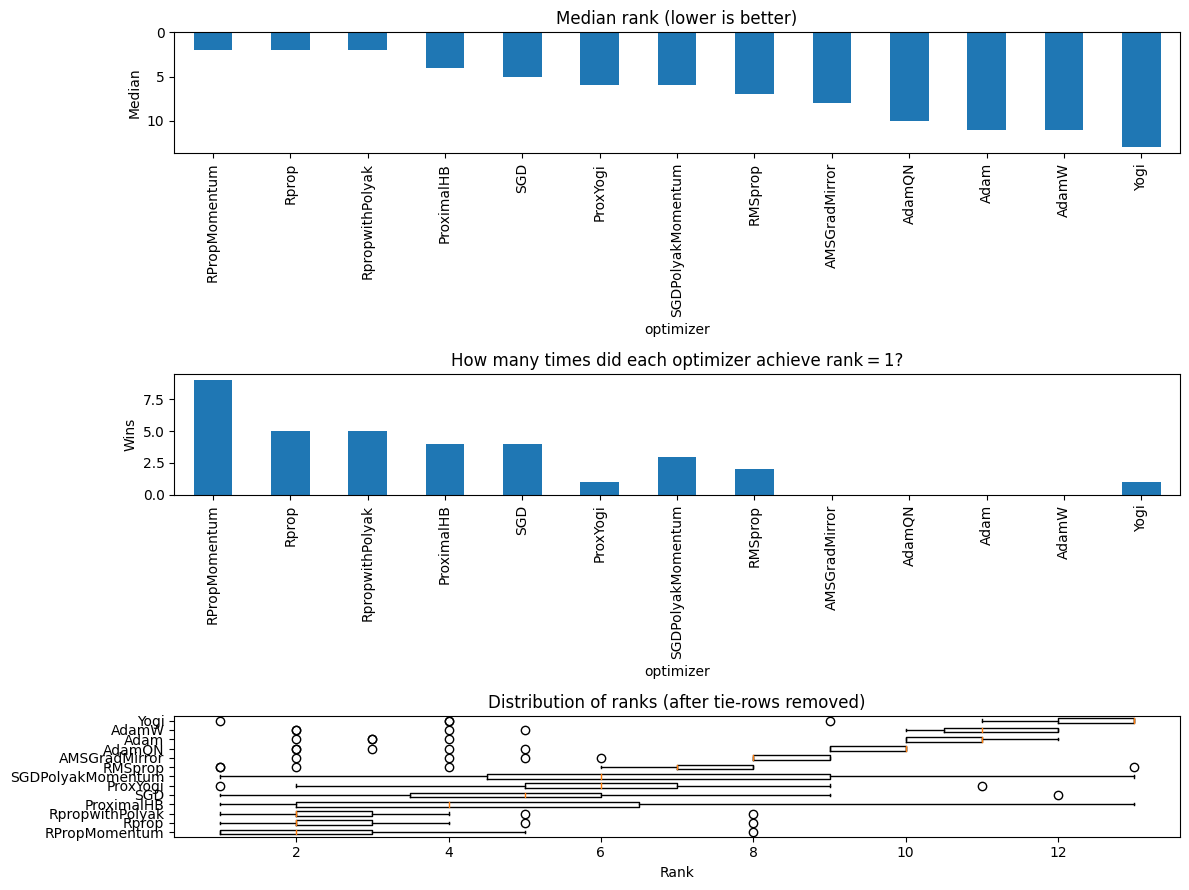

Friedman χ² = nan, p‑value = nan


,AMSGradMirror,Adam,AdamQN,AdamW,ProxYogi,ProximalHB,RMSprop,RPropMomentum,Rprop,RpropwithPolyak,SGD,SGDPolyakMomentum,Yogi
AMSGradMirror,1.000000,0.900000,0.900000,0.820636,0.900000,0.445067,0.900000,0.001000,0.004377,0.004377,0.303002,0.900000,0.210260
Adam,0.900000,1.000000,0.900000,0.900000,0.092330,0.003757,0.391128,0.001000,0.001000,0.001000,0.001575,0.210260,0.900000
AdamQN,0.900000,0.900000,1.000000,0.900000,0.748627,0.175660,0.900000,0.001000,0.001000,0.001000,0.102901,0.900000,0.496516
AdamW,0.820636,0.900000,0.900000,1.000000,0.053096,0.001706,0.269706,0.001000,0.001000,0.001000,0.001000,0.131845,0.900000
ProxYogi,0.900000,0.092330,0.748627,0.053096,1.000000,0.900000,0.900000,0.125397,0.364386,0.364386,0.900000,0.900000,0.001449
ProximalHB,0.445067,0.003757,0.175660,0.001706,0.900000,1.000000,0.900000,0.664615,0.900000,0.900000,0.900000,0.900000,0.001000
RMSprop,0.900000,0.391128,0.900000,0.269706,0.900000,0.900000,1.000000,0.018298,0.083704,0.083704,0.856640,0.900000,0.017110
RPropMomentum,0.001000,0.001000,0.001000,0.001000,0.125397,0.664615,0.018298,1.000000,0.900000,0.900000,0.796633,0.050020,0.001000
Rprop,0.004377,0.001000,0.001000,0.001000,0.364386,0.900000,0.083704,0.900000,1.000000,0.900000,0.900000,0.183871,0.001000
RpropwithPolyak,0.004377,0.001000,0.001000,0.001000,0.364386,0.900000,0.083704,0.900000,0.900000,1.000000,0.900000,0.183871,0.001000


In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import scikit_posthocs as sp
from scipy import stats

csv_path = "/home/yash/Codes/AOMML/Custom Optimizer and Benchmarking/results/functions/_summary.csv"
df_raw   = pd.read_csv(csv_path)

# ─────────────────────────────────────────────────────────────────────────
# 1 ▸ Pivot to rank‑matrix exactly as before
rank_tbl = (df_raw
            .pivot(index="function", columns="optimizer", values="rank")
            .sort_index())

# ─────────────────────────────────────────────────────────────────────────
# 2 ▸ Drop functions where all ranks are identical
uninformative_mask = rank_tbl.nunique(axis=1) == 1        # True → all ranks equal
neutral_funcs      = rank_tbl.index[uninformative_mask]
rank_tbl_filt      = rank_tbl[~uninformative_mask]

print(f"Dropped {uninformative_mask.sum()} / {len(rank_tbl)} functions "
      f"because every optimizer tied (list stored in 'neutral_funcs').")

# ─────────────────────────────────────────────────────────────────────────
# 3 ▸ Quick summaries that respect ties
median_ranks = rank_tbl_filt.median().sort_values()        # lower = better
win_counts   = (rank_tbl_filt == 1).sum().reindex(median_ranks.index)

# Save for later use
out_dir = "/home/yash/Codes/AOMML/Custom Optimizer and Benchmarking/results/functions"
rank_tbl_filt.to_csv(f"{out_dir}/rank_table_filtered.csv")
median_ranks.to_frame("median_rank").to_csv(f"{out_dir}/median_ranks.csv")
win_counts.to_frame("wins").to_csv(f"{out_dir}/rank1_counts.csv")

# ─────────────────────────────────────────────────────────────────────────
# 4 ▸ Plotting – three panes, shared x‑order = by median rank
plt.figure(figsize=(12, 9))

# 4a ▸ Median‑rank bar
plt.subplot(3, 1, 1)
median_ranks.plot(kind="bar")
plt.gca().invert_yaxis()
plt.title("Median rank (lower is better)")
plt.ylabel("Median")

# 4b ▸ Win count bar
plt.subplot(3, 1, 2)
win_counts.plot(kind="bar")
plt.title("How many times did each optimizer achieve rank = 1?")
plt.ylabel("Wins")

# 4c ▸ Rank‑distribution boxplot
plt.subplot(3, 1, 3)
plt.boxplot([rank_tbl_filt[c].dropna() for c in median_ranks.index],
            vert=False, labels=median_ranks.index)
plt.xlabel("Rank")
plt.title("Distribution of ranks (after tie‑rows removed)")

plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────────────────────────────────
# 5 ▸ Optional: Friedman test + Nemenyi critical‑difference diagram
#     (useful if you need formal significance)
stat, p = stats.friedmanchisquare(*[rank_tbl_filt[c].values for c in rank_tbl_filt])
print(f"Friedman χ² = {stat:.2f}, p‑value = {p:.3g}")

# Post‑hoc: will highlight groups that do *not* differ significantly
sp.posthoc_nemenyi_friedman(rank_tbl_filt)


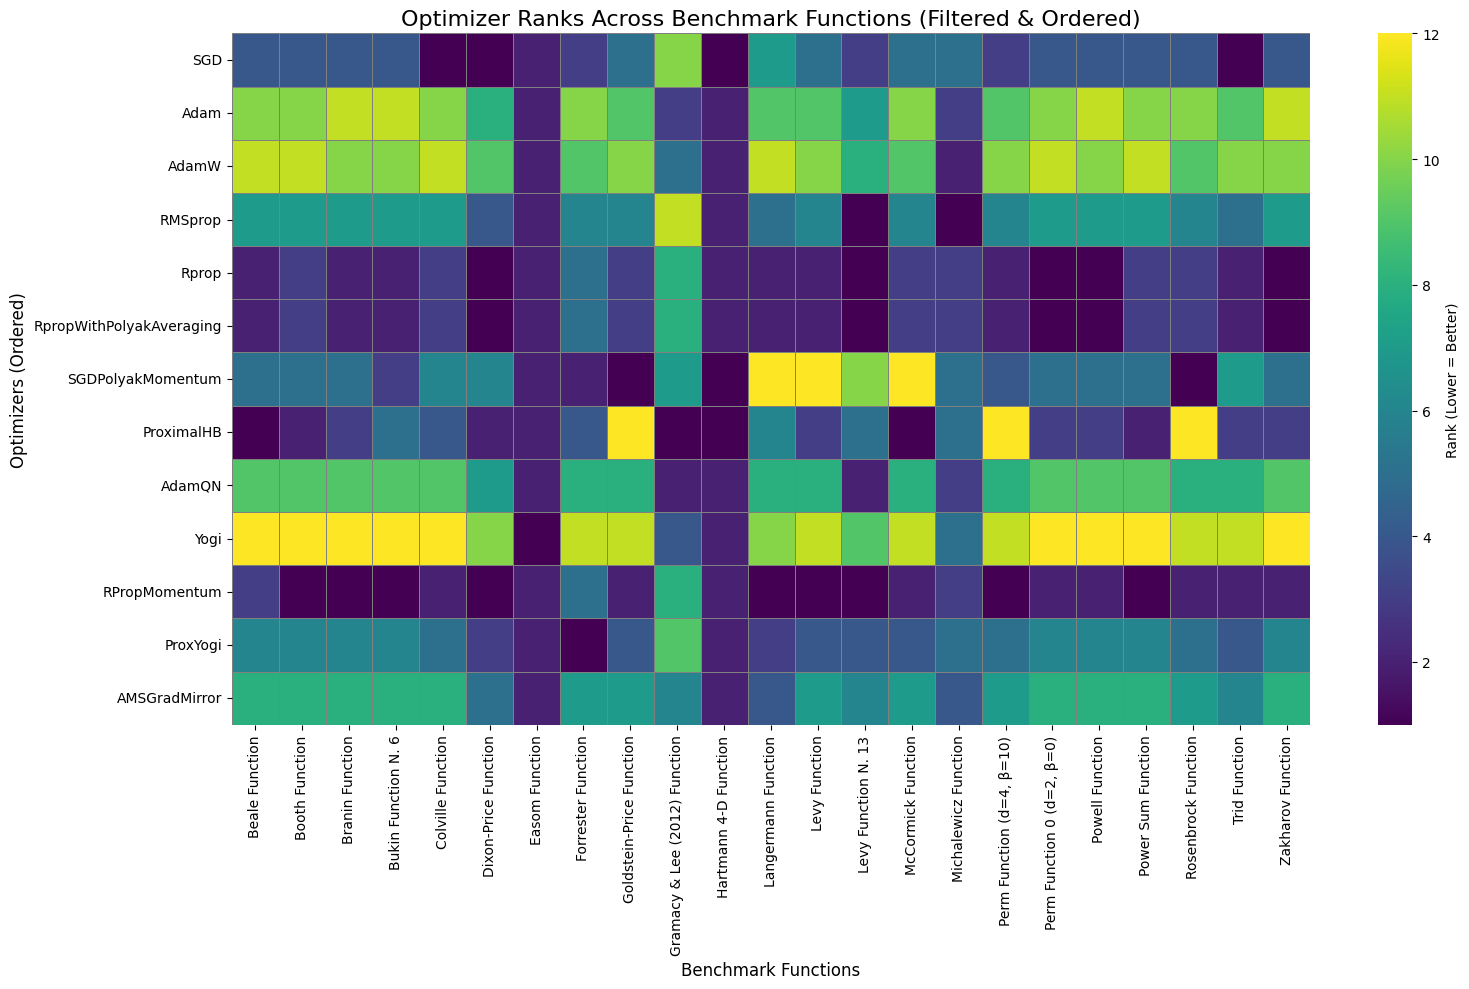

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Style dictionary from your specification
optimizer_styles = {
    'SGD':     {'linestyle': '-',  'color': 'blue'},
    'Adam':    {'linestyle': '-',  'color': 'orange'},
    'AdamW':   {'linestyle': '-',  'color': 'green'},
    'RMSprop': {'linestyle': '-',  'color': 'red'},
    'Rprop':   {'linestyle': '-',  'color': 'purple'},

    'RpropWithPolyakAveraging': {'linestyle': '--', 'color': 'brown'},
    'SGDPolyakMomentum':        {'linestyle': '--', 'color': 'pink'},
    'ProximalHB':               {'linestyle': '--', 'color': 'gray'},
    'AdamQN':                   {'linestyle': '--', 'color': 'olive'},

    'Yogi':          {'linestyle': ':',  'color': 'cyan'},
    'RPropMomentum': {'linestyle': ':',  'color': 'magenta'},
    'ProxYogi':      {'linestyle': ':',  'color': 'teal'},
    'AMSGradMirror': {'linestyle': ':',  'color': 'gold'},
}

# Load the data
path = "/home/yash/Codes/AOMML/Custom Optimizer and Benchmarking/results/functions/_summary.csv"
df = pd.read_csv(path)

# Fix naming inconsistency if any (e.g., 'RpropwithPolyak' vs. 'RpropWithPolyakAveraging')
df['optimizer'] = df['optimizer'].replace({
    'RpropwithPolyak': 'RpropWithPolyakAveraging'
})

# Compute ranks per function
df['rank'] = df.groupby('function')['min_abs_loss'].rank(method='dense', ascending=True)

# Pivot table: optimizers × functions
rank_matrix = df.pivot(index='optimizer', columns='function', values='rank')

# Remove functions with no rank variation (e.g. all optimizers rank 1)
rank_matrix = rank_matrix.loc[:, rank_matrix.apply(lambda x: x.nunique() > 1, axis=0)]

# Reorder optimizers according to optimizer_styles
ordered_optimizers = [opt for opt in optimizer_styles if opt in rank_matrix.index]
rank_matrix = rank_matrix.loc[ordered_optimizers]

# Plot heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(rank_matrix, cmap='viridis', annot=False, linewidths=0.5, linecolor='gray',
            cbar_kws={'label': 'Rank (Lower = Better)'})
plt.title("Optimizer Ranks Across Benchmark Functions (Filtered & Ordered)", fontsize=16)
plt.xlabel("Benchmark Functions", fontsize=12)
plt.ylabel("Optimizers (Ordered)", fontsize=12)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
